In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import display
import statsmodels.api as sm
import statsmodels.formula.api as smf

We will first download the data from data.cdc.gov

In [2]:
data = pd.read_csv("https://data.cdc.gov/api/views/u6jv-9ijr/rows.csv?accessType=DOWNLOAD")

We will drop all of the columns in the data that we will not use.

In [3]:
data.drop('Week Ending Date', axis = 1, inplace = True)
data.drop('State Abbreviation', axis = 1, inplace = True)
data.drop('Week', axis = 1, inplace = True)
data.drop('Cause Subgroup', axis = 1, inplace = True)
data.drop('Time Period', axis = 1, inplace = True)
data.drop('Suppress', axis = 1, inplace = True)
data.drop('Note', axis = 1, inplace = True)
data.drop('Average Number of Deaths in Time Period', axis = 1, inplace = True)
data.drop('Difference from 2015-2019 to 2020', axis = 1, inplace = True)
data.drop('Percent Difference from 2015-2019 to 2020', axis = 1, inplace = True)
data.drop('Type', axis = 1, inplace = True)

Since the dataset contains data from 2021 and we are not interested in 2021 data, we will drop this data.

In [4]:
data = data[data["Year"] != 2021]

Let's check for missing data.

In [5]:
data.isnull().sum()

Jurisdiction        0
Year                0
Cause Group         0
Number of Deaths    0
dtype: int64

Since there is no missing data, we can continue with our analysis. There is data in the dataset that has a jurisdiction of 'United States'. This means that out data is going to be doubled of what it really is so let's drop the observations that have a jurisdiction of 'United States' and only get the state jurisdiction.

In [6]:
display(data[data['Jurisdiction'] == 'United States'].head())
display(data[data['Jurisdiction'] == 'United States'].count())

,Jurisdiction,Year,Cause Group,Number of Deaths
30120,United States,2015,Alzheimer disease and dementia,6187.0
30121,United States,2015,Alzheimer disease and dementia,6187.0
30122,United States,2016,Alzheimer disease and dementia,5155.0
30123,United States,2016,Alzheimer disease and dementia,5155.0
30124,United States,2017,Alzheimer disease and dementia,5844.0


Jurisdiction        8138
Year                8138
Cause Group         8138
Number of Deaths    8138
dtype: int64

In [7]:
index = data[(data['Jurisdiction'] == 'United States')].index
data.drop(index, inplace = True)
display(data[data['Jurisdiction'] == 'United States'].count())

Jurisdiction        0
Year                0
Cause Group         0
Number of Deaths    0
dtype: int64

Let's change the column names so they don't have spaces.

In [8]:
data.columns = ['Jurisdiction', 'Year', 'CauseGroup', 'NumberOfDeaths']
data.head()

,Jurisdiction,Year,CauseGroup,NumberOfDeaths
0,Alabama,2015,Alzheimer disease and dementia,120.0
1,Alabama,2015,Alzheimer disease and dementia,120.0
2,Alabama,2016,Alzheimer disease and dementia,76.0
3,Alabama,2016,Alzheimer disease and dementia,76.0
4,Alabama,2017,Alzheimer disease and dementia,96.0


We will check the unique years in the dataset and make sure we only have 2015 through 2020.

In [9]:
data["Year"].unique()

array([2015, 2016, 2017, 2018, 2019, 2020])

Now, we will loop through all 6 years and seperate the data by year.

In [10]:
for year in data['Year'].unique():
    globals()['df_%s' % year] = data[data.Year == year].reset_index(drop = True)

In [11]:
sum_years = data.groupby([data.Year]).sum()

totalDeaths_all = int(sum(sum_years['NumberOfDeaths']))

i = 0
for year in sum_years.index:
    globals()['sum_%s' % year] = int(sum_years.iloc[i])
    i+=1

Let's get the total number of deaths per year along with the total deaths for all 6 years.

In [12]:
years = data['Year'].unique()

years_total = []
for year in years:
    years_total.append(str(year))
years_total.append('Total')

deaths = [item for item in sum_years['NumberOfDeaths']]
deaths.append(totalDeaths_all)

In [13]:
for i in range(len(deaths)):
    deaths[i] = int(deaths[i])

In [14]:
deaths

[4169620, 4185822, 4301084, 4343760, 4341442, 4635925, 25977653]

Now, we only need the deaths per year and we want to reverse them so we have 2020 deaths at index 0.

In [15]:
deaths_ = []
for item in deaths[:-1]:
    deaths_.insert(0,item)
print(deaths_)

[4635925, 4341442, 4343760, 4301084, 4185822, 4169620]


Let's get the population of the United States for all 6 of these years.

In [16]:
pop = pd.read_html("https://www.multpl.com/united-states-population/table/by-year")[0]

In [17]:
pop = pop.iloc[1:7,]

In [18]:
pop

,Date,Value Value
1,"Jul 1, 2020",329.88 million
2,"Jul 1, 2019",328.24 million
3,"Jul 1, 2018",326.69 million
4,"Jul 1, 2017",324.99 million
5,"Jul 1, 2016",322.94 million
6,"Jul 1, 2015",320.64 million


We only want to get year of the date column and the population in just a number so we will split both columns into lists and take the last index of the data column and index 0 of the value column and multiply the value column by 1,000,000 to get the actual population.

In [19]:
for i in range(len(pop)):
    lst1 = pop.iloc[i,0].split()
    pop.iloc[i,0] = lst1[-1]
    
    lst2 = pop.iloc[i,1].split()
    pop.iloc[i,1] = lst2[0]

In [20]:
pop.columns = ["Date", "Population"]

We will check the data types and if they aren't the right data types, we will convert them.

In [21]:
pop.dtypes

Date          object
Population    object
dtype: object

In [22]:
pop["Date"] = pd.to_numeric(pop["Date"])
pop["Population"] = pd.to_numeric(pop["Population"])

In [23]:
pop

,Date,Population
1,2020,329.88
2,2019,328.24
3,2018,326.69
4,2017,324.99
5,2016,322.94
6,2015,320.64


In [24]:
pop.dtypes

Date            int64
Population    float64
dtype: object

In [25]:
pop["Population"] = pop["Population"] * 1000000

In [26]:
pop["Population"] = pd.to_numeric(pop["Population"], downcast="integer")

In [27]:
pop

,Date,Population
1,2020,329880000
2,2019,328240000
3,2018,326690000
4,2017,324990000
5,2016,322940000
6,2015,320640000


Now, let's create another dataframe for the population and death rate.

In [28]:
pop_rate_df = pop.copy()

In [29]:
pop_rate_df["Total_Deaths"] = deaths_
pop_rate_df["Total_Rate"] = pop_rate_df["Total_Deaths"]/pop_rate_df["Population"]

In [30]:
pop_rate_df

,Date,Population,Total_Deaths,Total_Rate
1,2020,329880000,4635925,0.014053
2,2019,328240000,4341442,0.013226
3,2018,326690000,4343760,0.013296
4,2017,324990000,4301084,0.013235
5,2016,322940000,4185822,0.012962
6,2015,320640000,4169620,0.013004


Now, let's seperate the data by causes of death.

In [31]:
# Get Alzheimer deaths per year and store in a variable called 'deathsAlzheimer_year' where year is the actual year
for year in data['Year'].unique():
    globals()['deathsAlzheimer_%s' % year] = int(data.query(f"CauseGroup == 'Alzheimer disease and dementia' and Year == {year}")['NumberOfDeaths'].sum())

# Get Malignant deaths per year and store in a variable called 'deathsMalignant_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsMalignant_%s' % year] = int(data.query(f"CauseGroup == 'Malignant neoplasms' and Year == {year}")['NumberOfDeaths'].sum())

# Get Respiratory deaths per year and store in a variable called 'deathsRespiratory_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsRespiratory_%s' % year] = int(data.query(f"CauseGroup == 'Respiratory diseases' and Year == {year}")['NumberOfDeaths'].sum())

# Get Circulatory deaths per year and store in a variable called 'deathsCirculatory_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsCirculatory_%s' % year] = int(data.query(f"CauseGroup == 'Circulatory diseases' and Year == {year}")['NumberOfDeaths'].sum())
    
# Get Other deaths per year and store in a variable called 'deathsOther_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsOther_%s' % year] = int(data.query(f"CauseGroup == 'Other select causes' and Year == {year}")['NumberOfDeaths'].sum())

yearCauseDeaths = data.groupby([data.Year, data.CauseGroup]).sum().reset_index()

myDict = {}
for i in range(len(yearCauseDeaths)):
    if myDict == {}:
        myDict = {yearCauseDeaths.iloc[i,0]:[yearCauseDeaths.iloc[i,-1]]}
    else:
        if yearCauseDeaths.iloc[i,0] in myDict.keys():
            myDict[yearCauseDeaths.iloc[i,0]].append(yearCauseDeaths.iloc[i,-1])
        else:
            myDict.update({yearCauseDeaths.iloc[i,0]:[yearCauseDeaths.iloc[i,-1]]})

colNames = yearCauseDeaths["CauseGroup"].unique()
col_names = []

for item in colNames:
    col_names.append(item.split(" ")[0])

df_deathsCausePerYear = pd.DataFrame(myDict.values(), columns = col_names)
df_deathsCausePerYear

years = myDict.keys()

df_deathsCausePerYear.insert(0, "Year", years)

display(df_deathsCausePerYear)

,Year,Alzheimer,Circulatory,Malignant,Other,Respiratory
0,2015,490130.0,1649122.0,1196044.0,314026.0,520298.0
1,2016,498712.0,1658822.0,1200410.0,315756.0,512122.0
2,2017,525012.0,1702588.0,1207174.0,326626.0,539684.0
3,2018,535206.0,1722912.0,1207218.0,330710.0,547714.0
4,2019,544754.0,1733834.0,1208100.0,331254.0,523500.0
5,2020,621419.0,1875160.0,1233403.0,373682.0,532261.0


Convert the values from float to integer.

In [32]:
df_deathsCausePerYear["Alzheimer"] = pd.to_numeric(df_deathsCausePerYear["Alzheimer"], downcast="integer")
df_deathsCausePerYear["Circulatory"] = pd.to_numeric(df_deathsCausePerYear["Circulatory"], downcast="integer")
df_deathsCausePerYear["Malignant"] = pd.to_numeric(df_deathsCausePerYear["Malignant"], downcast="integer")
df_deathsCausePerYear["Other"] = pd.to_numeric(df_deathsCausePerYear["Other"], downcast="integer")
df_deathsCausePerYear["Respiratory"] = pd.to_numeric(df_deathsCausePerYear["Respiratory"], downcast="integer")

df_deathsCausePerYear

,Year,Alzheimer,Circulatory,Malignant,Other,Respiratory
0,2015,490130,1649122,1196044,314026,520298
1,2016,498712,1658822,1200410,315756,512122
2,2017,525012,1702588,1207174,326626,539684
3,2018,535206,1722912,1207218,330710,547714
4,2019,544754,1733834,1208100,331254,523500
5,2020,621419,1875160,1233403,373682,532261


We need to reverse the number of deaths so that 2020 is at the first index.

In [33]:
alz = []
circ = []
malig = []
oth = []
resp = []
for item in df_deathsCausePerYear["Alzheimer"]:
    alz.insert(0,item)
for item in df_deathsCausePerYear["Circulatory"]:
    circ.insert(0,item)
for item in df_deathsCausePerYear["Malignant"]:
    malig.insert(0,item)
for item in df_deathsCausePerYear["Other"]:
    oth.insert(0,item)
for item in df_deathsCausePerYear["Respiratory"]:
    resp.insert(0,item)
print(alz)
print(circ)
print(malig)
print(oth)
print(resp)

[621419, 544754, 535206, 525012, 498712, 490130]
[1875160, 1733834, 1722912, 1702588, 1658822, 1649122]
[1233403, 1208100, 1207218, 1207174, 1200410, 1196044]
[373682, 331254, 330710, 326626, 315756, 314026]
[532261, 523500, 547714, 539684, 512122, 520298]


In [34]:
cat_deaths_rate_df = pop_rate_df

In [35]:
cat_deaths_rate_df = cat_deaths_rate_df.rename(columns={"Total_Rate":"Death_Rate"})

Let's put the data of deaths into a dataframe called 'cat_deaths_rate_df'.

In [36]:
cat_deaths_rate_df["Alzheimer"] = alz
cat_deaths_rate_df["Circulatory"] = circ
cat_deaths_rate_df["Malignant"] = malig
cat_deaths_rate_df["Other"] = oth
cat_deaths_rate_df["Respiratory"] = resp

Now, we will get the rate of death per cause by dividing the number of deaths per cause per year by the number of total deaths per year and remove all of the total deaths per cause per year and total deaths per year.

In [37]:
cat_deaths_rate_df["Alz_Rate"] = cat_deaths_rate_df["Alzheimer"]/cat_deaths_rate_df["Total_Deaths"]
cat_deaths_rate_df["Circ_Rate"] = cat_deaths_rate_df["Circulatory"]/cat_deaths_rate_df["Total_Deaths"]
cat_deaths_rate_df["Malig_Rate"] = cat_deaths_rate_df["Malignant"]/cat_deaths_rate_df["Total_Deaths"]
cat_deaths_rate_df["Other_Rate"] = cat_deaths_rate_df["Other"]/cat_deaths_rate_df["Total_Deaths"]
cat_deaths_rate_df["Resp_Rate"] = cat_deaths_rate_df["Respiratory"]/cat_deaths_rate_df["Total_Deaths"]

cat_deaths_rate_df

,Date,Population,Total_Deaths,Death_Rate,Alzheimer,Circulatory,Malignant,Other,Respiratory,Alz_Rate,Circ_Rate,Malig_Rate,Other_Rate,Resp_Rate
1,2020,329880000,4635925,0.014053,621419,1875160,1233403,373682,532261,0.134044,0.404485,0.266053,0.080606,0.114812
2,2019,328240000,4341442,0.013226,544754,1733834,1208100,331254,523500,0.125478,0.399368,0.278272,0.076300,0.120582
3,2018,326690000,4343760,0.013296,535206,1722912,1207218,330710,547714,0.123213,0.396641,0.277920,0.076135,0.126092
4,2017,324990000,4301084,0.013235,525012,1702588,1207174,326626,539684,0.122065,0.395851,0.280667,0.075940,0.125476
5,2016,322940000,4185822,0.012962,498712,1658822,1200410,315756,512122,0.119143,0.396295,0.286780,0.075435,0.122347
6,2015,320640000,4169620,0.013004,490130,1649122,1196044,314026,520298,0.117548,0.395509,0.286847,0.075313,0.124783


In [38]:
cat_deaths_rate_df = cat_deaths_rate_df.drop(columns=["Population", "Total_Deaths", "Alzheimer", "Circulatory", "Malignant", "Other", "Respiratory"])

In [39]:
cat_deaths_rate_df

,Date,Death_Rate,Alz_Rate,Circ_Rate,Malig_Rate,Other_Rate,Resp_Rate
1,2020,0.014053,0.134044,0.404485,0.266053,0.080606,0.114812
2,2019,0.013226,0.125478,0.399368,0.278272,0.076300,0.120582
3,2018,0.013296,0.123213,0.396641,0.277920,0.076135,0.126092
4,2017,0.013235,0.122065,0.395851,0.280667,0.075940,0.125476
5,2016,0.012962,0.119143,0.396295,0.286780,0.075435,0.122347
6,2015,0.013004,0.117548,0.395509,0.286847,0.075313,0.124783


Below is the population, total deaths, and total rate dataframe.

In [40]:
pop_rate_df

,Date,Population,Total_Deaths,Total_Rate
1,2020,329880000,4635925,0.014053
2,2019,328240000,4341442,0.013226
3,2018,326690000,4343760,0.013296
4,2017,324990000,4301084,0.013235
5,2016,322940000,4185822,0.012962
6,2015,320640000,4169620,0.013004


Let's plot the cause of deaths per year.

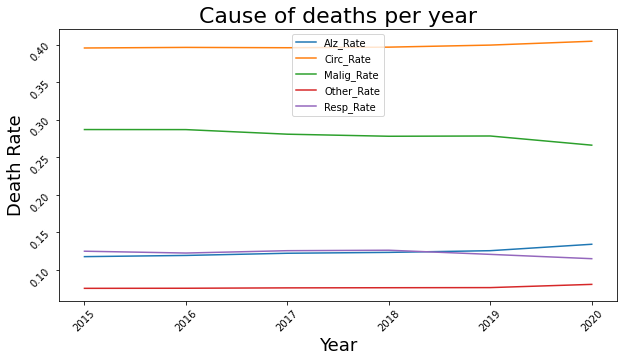

In [41]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot("Date", "Alz_Rate", data=cat_deaths_rate_df)
plt.plot("Date", "Circ_Rate", data=cat_deaths_rate_df)
plt.plot("Date", "Malig_Rate", data=cat_deaths_rate_df)
plt.plot("Date", "Other_Rate", data=cat_deaths_rate_df)
plt.plot("Date", "Resp_Rate", data=cat_deaths_rate_df)
plt.title("Cause of deaths per year", size = 22)
plt.xlabel("Year", size = 18)
plt.ylabel("Death Rate", size = 18)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.legend()
plt.show()

Now, let's plot the total deaths per year with a barplot.

In [42]:
pop_rate_df

,Date,Population,Total_Deaths,Total_Rate
1,2020,329880000,4635925,0.014053
2,2019,328240000,4341442,0.013226
3,2018,326690000,4343760,0.013296
4,2017,324990000,4301084,0.013235
5,2016,322940000,4185822,0.012962
6,2015,320640000,4169620,0.013004


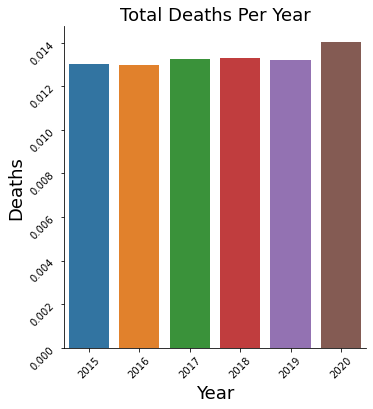

In [43]:
sns.catplot(x="Date", y="Total_Rate", kind="bar", data=pop_rate_df)
plt.title("Total Deaths Per Year", size=18)
plt.xlabel("Year", size=18)
plt.ylabel("Deaths", size=18)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## Conclusion

The total death rate per population for every year starting with 2015 and ending with 2020 is 0.013004, 0.012962, 0.013235, 0.013296, 0.013226, and 0.014053 which is not a significant difference.


The death rate per cause is about the same for every year for every cause so there is no significant difference.

The line graph indicates a clear picture that there is no significant difference in causes of death per year with circulatory being the leading cause of death and malignant being the second highest cause of death. Alzheimer and respiratory are about the same.

The barplot indicates that there is no significant difference in deaths per year.